In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.7.0


In [2]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
print("Min Intensity ",data_info.Vmax.min())
print("Min Intensity ",data_info.Vmax.max())
print("Min Intensity ",round(data_info.Vmax.mean(),2))

Min Intensity  15.0
Min Intensity  155.0
Min Intensity  48.14


In [4]:
np.shape(data_matrix)

(4580, 201, 201, 4)

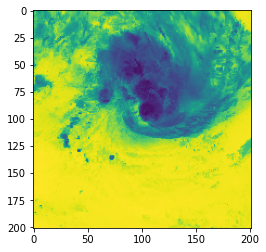

In [5]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

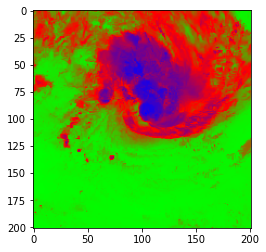

In [6]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

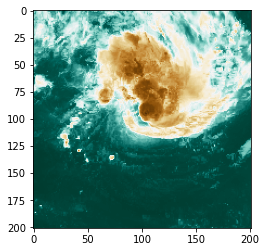

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.BrBG)

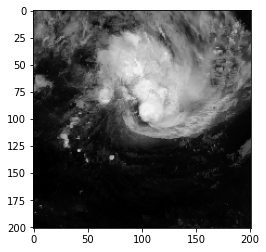

In [8]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

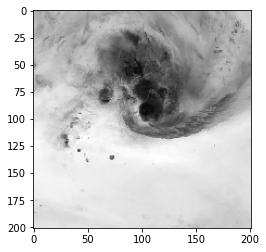

In [9]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [10]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [11]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [12]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

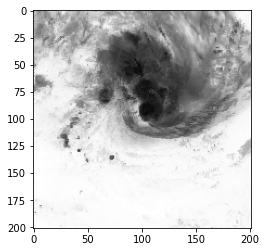

In [13]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [15]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Alexnet CNN

In [16]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='relu'),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )
 
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [17]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=256
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
15/15 [==============================] - 63s 4s/step - loss: 22842.6445 - mean_squared_error: 22842.6445
Epoch 2/20
15/15 [==============================] - 58s 4s/step - loss: 1025.1450 - mean_squared_error: 1025.1450
Epoch 3/20
15/15 [==============================] - 51s 3s/step - loss: 932.5684 - mean_squared_error: 932.5684
Epoch 4/20
15/15 [==============================] - 54s 4s/step - loss: 908.1125 - mean_squared_error: 908.1125
Epoch 5/20
15/15 [==============================] - 61s 4s/step - loss: 878.0404 - mean_squared_error: 878.0404
Epoch 6/20
15/15 [==============================] - 50s 3s/step - loss: 850.0797 - mean_squared_error: 850.0797
Epoch 7/20
15/15 [==============================] - 54s 4s/step - loss: 826.0714 - mean_squared_error: 826.0714
Epoch 8/20
15/15 [==============================] - 56s 4s/step - loss: 818.8555 - mean_squared_error: 818.8555
Epoch 9/20
15/15 [==============================] - 56s 4s/step - loss: 786.4831 - mean_squared_er

In [18]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)

print('Test accuracy:', score[1])

Testing...
26/26 [==============================] - 2s 51ms/step - loss: 526.2440 - mean_squared_error: 526.2440
Test accuracy: 526.2440185546875


In [19]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [23]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [26]:
cate_dataset = list(zip(abcd,cate))

In [32]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [33]:
df

,Intensity,Category
0,63,Tropical Storm
1,45,Tropical Storm
2,31,Tropical Depression
3,79,Typhoon
4,55,Tropical Storm
...,...,...
408,43,Tropical Storm
409,36,Tropical Storm
410,35,Tropical Storm
411,32,Tropical Depression


## Deep CNN

In [34]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [35]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
58/58 [==============================] - 11s 138ms/step - loss: 1218.4020 - mean_squared_error: 1218.3943
Epoch 2/10
58/58 [==============================] - 8s 135ms/step - loss: 789.0946 - mean_squared_error: 789.0878
Epoch 3/10
58/58 [==============================] - 8s 138ms/step - loss: 778.8297 - mean_squared_error: 778.8234
Epoch 4/10
58/58 [==============================] - 7s 127ms/step - loss: 648.1212 - mean_squared_error: 648.1151
Epoch 5/10
58/58 [==============================] - 8s 132ms/step - loss: 511.7973 - mean_squared_error: 511.7913
Epoch 6/10
58/58 [==============================] - 7s 124ms/step - loss: 466.6028 - mean_squared_error: 466.5965
Epoch 7/10
58/58 [==============================] - 7s 127ms/step - loss: 405.2122 - mean_squared_error: 405.2061
Epoch 8/10
58/58 [==============================] - 8s 130ms/step - loss: 359.7883 - mean_squared_error: 359.7821
Epoch 9/10
58/58 [==============================] - 8s 140ms/step - loss: 351.2440 - 

In [36]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

Testing...
26/26 [==============================] - 1s 12ms/step - loss: 341.8333 - mean_squared_error: 341.8269
Test accuracy: 341.826904296875


In [37]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [38]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [39]:
cate_dataset = list(zip(abcd,cate))

In [40]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [41]:
df

,Intensity,Category
0,47,Tropical Storm
1,39,Tropical Storm
2,31,Tropical Depression
3,84,Typhoon
4,35,Tropical Storm
...,...,...
408,36,Tropical Storm
409,40,Tropical Storm
410,35,Tropical Storm
411,35,Tropical Storm


## Kfold 

In [43]:
n_epochs=5
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/5
96/96 [==============================] - 12s 79ms/step - loss: 2556.8972 - mean_squared_error: 2556.8933
Epoch 2/5
96/96 [==============================] - 7s 73ms/step - loss: 2556.8943 - mean_squared_error: 2556.8933
Epoch 3/5
96/96 [==============================] - 8s 79ms/step - loss: 2556.8933 - mean_squared_error: 2556.8933
Epoch 4/5
96/96 [==============================] - 7s 75ms/step - loss: 1916.2208 - mean_squared_error: 1916.2205
Epoch 5/5
48/48 [==============================] - 1s 17ms/step - loss: 1068.2166 - mean_squared_error: 1068.2164
Val Score:  [1068.216552734375, 1068.2164306640625]


Training on Fold:  2
Epoch 1/5
96/96 [==============================] - 15s 104ms/step - loss: 1092.3606 - mean_squared_error: 1092.3530
Epoch 2/5
96/96 [==============================] - 9s 91ms/step - loss: 825.1227 - mean_squared_error: 825.1169
Epoch 3/5
96/96 [==============================] - 9s 89ms/step - loss: 546.4724 - mean_squared_error: 54

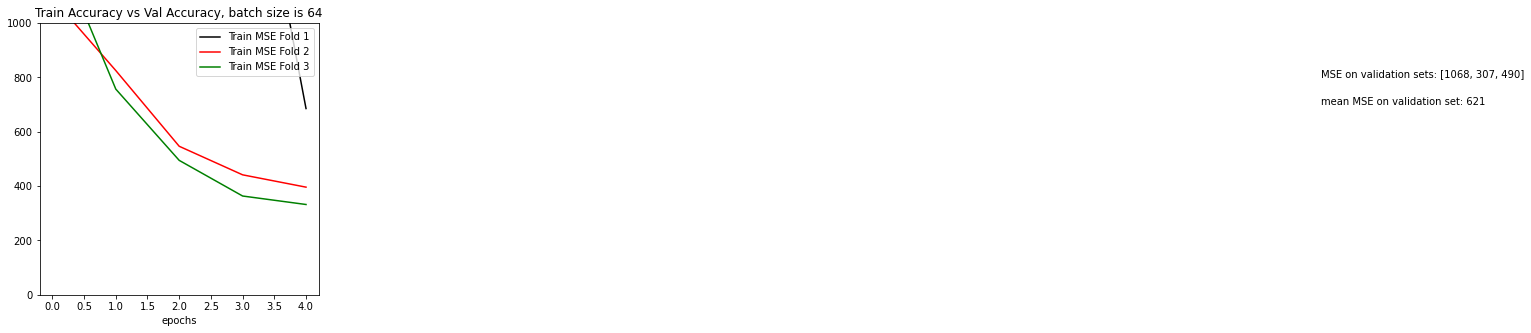

In [50]:
plt.figure(figsize=(5,5))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()